# Robot de Almacén

### Datos a considerar
- La semilla para generación de números aleatorios será 67890.
- El almacén es 20x20 celdas.
- Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
- Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
- La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.


### Resultados
-	Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
-	Una visualización que permita ver los diferentes pasos de la simulación.
-	El número de pasos necesarios para terminar la simulación.
-	¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?


### Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [41]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import random

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [42]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.id = id
        self.box = ()
        self.target = ()
        self.box_positions = np.zeros(
              (model.grid.width, model.grid.height), dtype=int)

    def step(self):
        new_position = ()
        possible_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center = False)

        for cell in possible_cells:
            (x, y) = cell
            # Verify if there's a box in neighbors
            if(self.model.boxes[x][y] > 0 ):
              self.box_positions[x][y] = self.model.boxes[x][y]

              # If robot has box, place it
              if(len(self.box) > 0 and self.model.boxes[x][y] < 5):
                  self.box = ()
                  self.model.boxes[x][y] += 1
                  self.box_positions[x][y] += 1
                  self.model.picked_boxes -= 1

              # If robot has no box, pick the box
              if(len(self.box) == 0 and self.model.boxes[x][y] < 3):
                  self.box = (x, y)
                  self.model.boxes[x][y] -= 1
                  self.box_positions[x][y] -= 1
                  self.model.picked_boxes += 1

        # Choose a new cell to move and verify if it's empty of boxes and robots
        new_position = random.choice(possible_cells)
        while(self.model.boxes[new_position] > 0 or self.box_positions[new_position] > 0):
            new_position = random.choice(possible_cells)

        self.model.grid.move_agent(self, new_position)
        self.pos = new_position
        # print(f"Agent {self.id} moved to {self.pos}")

In [43]:
def get_robots(model):
    return np.asarray([agent.pos for agent in model.schedule.agents])

In [44]:
def get_boxes(model):
    return model.boxes

In [45]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, torus=False)
        self.boxes = np.zeros((width, height), dtype=int)
        self.datacollector = DataCollector(model_reporters={"Robot": get_robots, "Boxes": get_boxes})
        self.picked_boxes = 0

        init_boxes = 0
        while init_boxes < num_boxes:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if self.boxes[x, y] < 3:
              self.boxes[x, y] += 1
              init_boxes += 1

        agent_pos = []
        while len(agent_pos) < num_agents:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if (x, y) not in agent_pos and self.boxes[x, y] == 0:
                agent = RobotAgent(len(agent_pos), self)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x, y))
                agent_pos.append((x, y))


        # print(f"Initial boxes: \n{self.boxes}\n")
        # print(f"Initial agents: \n{agent_pos}\n")

    def step(self):
         self.datacollector.collect(self)
         self.schedule.step()

In [46]:
WIDTH = 20
HEIGHT = 20
ROBOTS = 5
ITERATIONS = 1000
MAX_BOXES = 200
SEED = 67890
random.seed(SEED)

In [47]:
model = WarehouseModel(WIDTH, HEIGHT, ROBOTS, MAX_BOXES)
all_box_data = []
for i in range(ITERATIONS):
    model.step()
    all_box_data.append(model.datacollector.get_model_vars_dataframe()["Boxes"].iloc[0].copy())

print(f"Final boxes: \n{model.picked_boxes}\n")

Final boxes: 
5



In [48]:
all_positions = model.datacollector.get_model_vars_dataframe()

In [49]:
# for i in range(ITERATIONS):
#   print(all_positions.iloc[i][0])

C:\Users\sgarn\AppData\Local\Temp\ipykernel_24384\2148707644.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
C:\Users\sgarn\AppData\Local\Temp\ipykernel_24384\2148707644.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])


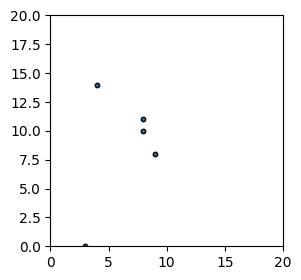

In [50]:
fig, ax = plt.subplots(figsize=(3, 3))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = ITERATIONS)

In [51]:
# anim

Total boxes: 195


C:\Users\sgarn\AppData\Local\Temp\ipykernel_24384\2630050741.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  box_positions = all_positions.iloc[0][1]


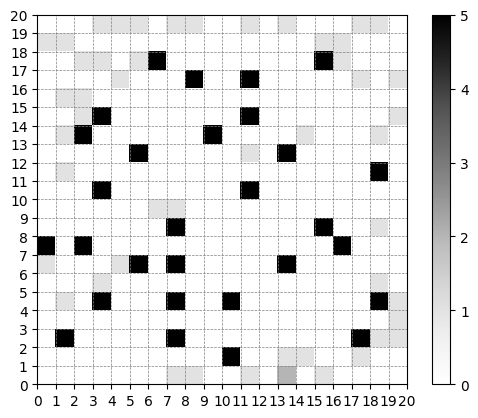

In [52]:
box_positions = all_positions.iloc[0][1]
box_counts = np.zeros((WIDTH, HEIGHT), dtype=int)

c = 0

for x in range(model.grid.width):
    for y in range(model.grid.height):
      box_counts[y][x] = box_positions[x][y]
      c += box_positions[x][y]

print(f"Total boxes: {c}")

cmap = plt.cm.Greys

plt.imshow(box_counts, cmap=cmap, interpolation='nearest', origin="lower", extent=[0, HEIGHT, 0, WIDTH])
plt.colorbar()

# Set ticks for both axes
plt.xticks(np.arange(0, HEIGHT+1, 1))
plt.yticks(np.arange(0, WIDTH+1, 1))

# Add grid lines
plt.grid(color='gray', linestyle='--', linewidth=0.5)

In [53]:
# # Plot the box positions for each iteration
# fig, axs = plt.subplots(nrows=ITERATIONS, figsize=(4, 4 * ITERATIONS))

# for i in range(ITERATIONS, ):
#     box_positions = all_box_data[i]
#     box_counts = np.zeros((WIDTH, HEIGHT), dtype=int)

#     for x in range(model.grid.width):
#         for y in range(model.grid.height):
#             box_counts[y][x] = box_positions[x][y]

#     axs[i].imshow(box_counts, interpolation='nearest', origin="lower", extent=[0, HEIGHT, 0, WIDTH])
#     axs[i].set_title(f"Iteration {i + 1}")

#     # Set ticks for both axes
#     axs[i].set_xticks(np.arange(0, HEIGHT + 1, 1))
#     axs[i].set_yticks(np.arange(0, WIDTH + 1, 1))

#     # Add grid lines
#     axs[i].grid(color='gray', linestyle='--', linewidth=0.5)

# plt.tight_layout()
# plt.show()
